# Recurrent Neural Network 
## Temperature-Forecasting using TensorFlow

[References]
- [TensorFlow Time Series Forecasting Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
- [Deep Learning with Python 2nd Edition, Chapter 10 Deep Learning for time series](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from data_preprocess import X, y, num_train_samples, num_val_samples, num_test_samples

num_train_samples: 252270
num_val_samples: 84090
num_test_samples: 84091


In [3]:
num_features = X.shape[1]
print('Number of features:', num_features)

Number of features: 14


## Data Generator

### Understanding `timeseries_dataset_from_array()`

We want to use a `data generator` that yields batches of data samples. Let's take a look at a simple example.

In [4]:
import numpy as np

# Tensorflow version = 2.4.1
int_sequence = np.arange(30)
dummy_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=int_sequence[:-6],
    targets=int_sequence[6:],
    sequence_length=3,
    sequence_stride=3,   # Default = 1
    sampling_rate=2,     # Default = 1
    batch_size=2,
    shuffle=True
)

# 텐서플로우 버전에 따라 함수 클래스가 다릅니다. (최신 버전의 경우 아래 함수 사용)
# dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
#     data=int_sequence[:-3],
#     targets=int_sequence[3:],
#     sequence_length=3,
#     batch_size=2
# )

for inputs, targets in dummy_dataset:
    # inputs shape : (batch_size, sequence_length)
    # targets shape : (batch_size, )
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[12, 14, 16] 18
[3, 5, 7] 9
[0, 2, 4] 6
[9, 11, 13] 15
[15, 17, 19] 21
[6, 8, 10] 12
[18, 20, 22] 24


2023-02-02 13:12:27.665780: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-02 13:12:27.666148: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 13:12:27.735148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


### Instantiating datasets for training, validation, and testing

In [5]:
# Observations will be sampled at one data point per hour
sampling_rate = 6

# Observations will go back 5 days (120 hours)
sequence_length = 120

# The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
    )

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
    )

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
    end_index=None
    )

In [7]:
for samples, targets in train_dataset:
    print('samples shape:', samples.shape)
    print('targets shape:', targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## RNN models

### SimpleRNN

[Reference: 오승상 딥러닝](https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M)
![SimpleRNN](SimpleRNN.png)

In [8]:
print('The number of features:', num_features)
print('The sequence length:', sequence_length)

The number of features: 14
The sequence length: 120


**Note: An RNN layer is capable of processing sequences of any length.**

- If we try to train a model with sequence data of arbitrary length, we set `sequence_length=None` in the `Input` layer.
- Clearly, sequence dataset of arbitrary length cannot be trained using minibatch. That is, we should set `batch_size=1`.


In [9]:
input_tensor = Input(shape=(sequence_length, num_features))
x = SimpleRNN(units=16, return_sequences=False)(input_tensor)
x = Dense(units=1, activation=None)(x)

model = Model(inputs=input_tensor, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='mse', metrics=['mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                496       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


#### Let's check the number of parameters in RNN

- `num_features = 14` $\quad \to \quad$ dimension of $x_t$
- `hidden_state = 16` $\quad \to \quad$ dimension of $h_t$

**Computation of RNN core** : 
$h_t = \tanh(W_{xh}x_t + W_{hh} h_{t-1} + b_h) $

- $W_{xh}$ size : 14 $\times$ 16
- $W_{hh}$ size : 16 $\times$ 16
- $b_h$ size : 16
- Total : $14 \times 16 + 16 \times 16 + 16 = (14+16+1) \times 16 = 496$

In [10]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
983/983 [==============================] - 35s 35ms/step - loss: 82.2748 - mse: 82.2748 - val_loss: 13.8977 - val_mse: 13.8977
Epoch 2/10
983/983 [==============================] - 30s 30ms/step - loss: 14.7030 - mse: 14.7030 - val_loss: 10.6920 - val_mse: 10.6920
Epoch 3/10
983/983 [==============================] - 30s 30ms/step - loss: 11.0858 - mse: 11.0858 - val_loss: 10.1873 - val_mse: 10.1873
Epoch 4/10
983/983 [==============================] - 30s 31ms/step - loss: 10.3338 - mse: 10.3338 - val_loss: 9.9675 - val_mse: 9.9675
Epoch 5/10
983/983 [==============================] - 31s 31ms/step - loss: 10.0206 - mse: 10.0206 - val_loss: 9.8240 - val_mse: 9.8240
Epoch 6/10
983/983 [==============================] - 30s 30ms/step - loss: 9.8385 - mse: 9.8385 - val_loss: 9.8214 - val_mse: 9.8214
Epoch 7/10
983/983 [==============================] - 32s 33ms/step - loss: 9.7190 - mse: 9.7190 - val_loss: 9.8580 - val_mse: 9.8580
Epoch 8/10
983/983 [==========================

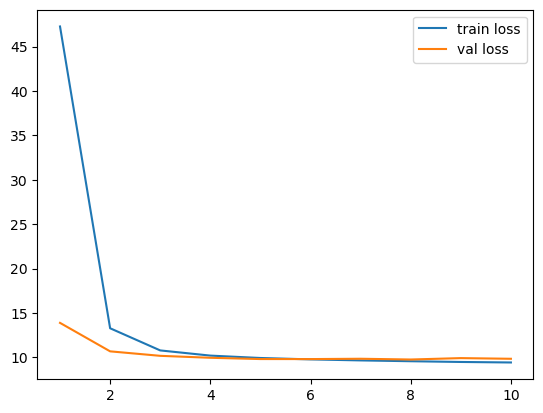

In [24]:
plt.plot(np.arange(1,10+1), history.history['loss'], label='train loss')
plt.plot(np.arange(1,10+1), history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [56]:
test_targets = np.empty([0])
print(test_targets)

for data in test_dataset:
    test_targets = np.append(test_targets, data[1])

test_num = test_targets.shape[0]
print(test_num)

[]
(82514,)


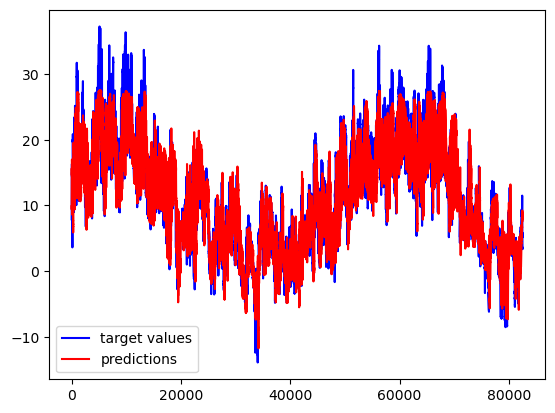

In [17]:
predictions = model.predict(test_dataset)
predictions = predictions.reshape((test_num,))

x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions, label = 'predictions', color='r')
plt.title('Vanilla RNN prediction')
plt.legend()
plt.show()

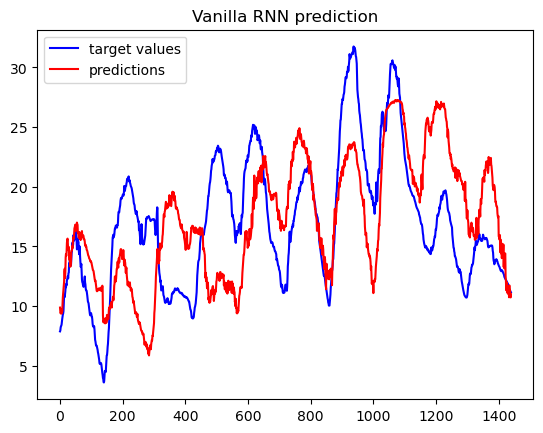

In [32]:
x = np.arange(1440)
plt.plot(x, test_targets[:1440], label = 'target values', color='b')
plt.plot(x, predictions[:1440], label = 'predictions', color='r')
plt.title('Vanilla RNN prediction')
plt.legend()
plt.show()

### Stacked RNN

In [18]:
input_tensor = Input(shape=(sequence_length, num_features))
x = SimpleRNN(units=16, return_sequences=True)(input_tensor)
x = SimpleRNN(units=16, return_sequences=False)(x)
x = Dense(units=1, activation=None)(x)

model2 = Model(inputs=input_tensor, outputs=x)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='mse', metrics=['mse'])

model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 120, 16)           496       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,041
Trainable params: 1,041
Non-trainable params: 0
_________________________________________________________________


**You should try to check the number of parameters in the second RNN layer!**

In [19]:
history2 = model2.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
983/983 [==============================] - 63s 62ms/step - loss: 73.6963 - mse: 73.6963 - val_loss: 13.7422 - val_mse: 13.7422
Epoch 2/10
983/983 [==============================] - 56s 57ms/step - loss: 14.2873 - mse: 14.2873 - val_loss: 10.5734 - val_mse: 10.5734
Epoch 3/10
983/983 [==============================] - 47s 48ms/step - loss: 10.9226 - mse: 10.9226 - val_loss: 10.2234 - val_mse: 10.2234
Epoch 4/10
983/983 [==============================] - 45s 46ms/step - loss: 10.1499 - mse: 10.1499 - val_loss: 9.8187 - val_mse: 9.8187
Epoch 5/10
983/983 [==============================] - 43s 44ms/step - loss: 9.7438 - mse: 9.7438 - val_loss: 9.6229 - val_mse: 9.6229
Epoch 6/10
983/983 [==============================] - 47s 48ms/step - loss: 9.5594 - mse: 9.5594 - val_loss: 9.5564 - val_mse: 9.5564
Epoch 7/10
983/983 [==============================] - 45s 46ms/step - loss: 9.3313 - mse: 9.3313 - val_loss: 9.4261 - val_mse: 9.4261
Epoch 8/10
983/983 [============================

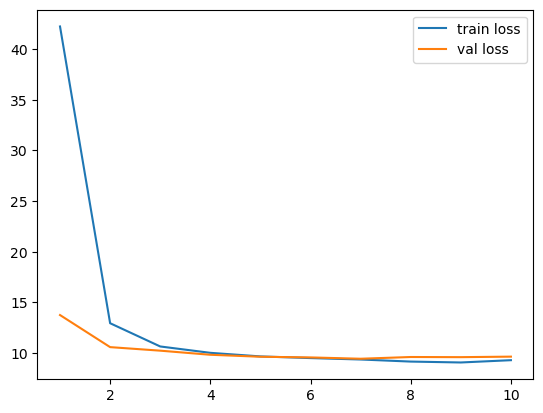

In [25]:
plt.plot(np.arange(1,10+1), history2.history['loss'], label='train loss')
plt.plot(np.arange(1,10+1), history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()

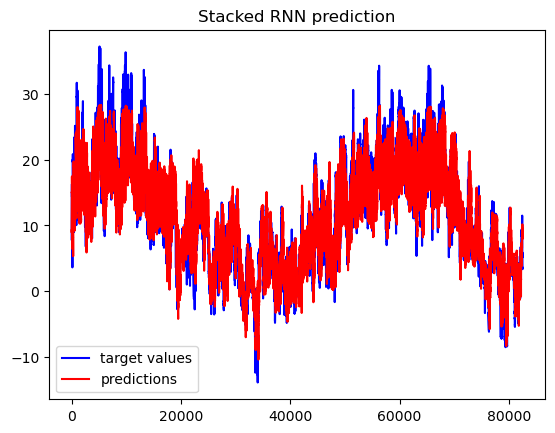

In [20]:
predictions2 = model2.predict(test_dataset)
predictions2 = predictions2.reshape((test_num,))

x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions2, label = 'predictions', color='r')
plt.title('Stacked RNN prediction')
plt.legend()
plt.show()

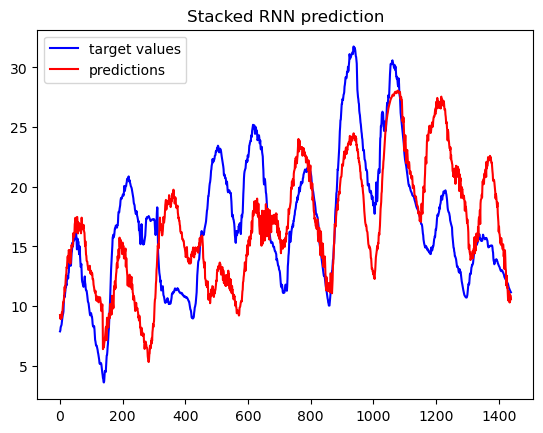

In [29]:
x = np.arange(1440)
plt.plot(x, test_targets[:1440], label = 'target values', color='b')
plt.plot(x, predictions2[:1440], label = 'predictions', color='r')
plt.title('Stacked RNN prediction')
plt.legend()
plt.show()

### LSTM 

[Reference: 오승상 딥러닝](https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M)
![LSTM](LSTM.png)

In [21]:
input_tensor = Input(shape=(sequence_length, num_features))
x = LSTM(units=16, return_sequences=False)(input_tensor)
x = Dense(units=1, activation=None)(x)

model3 = Model(inputs=input_tensor, outputs=x)
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='mse', metrics=['mse'])

model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1984      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


#### Let's check the number of parameters in LSTM

- `num_features = 14` $\quad \to \quad$ dimension of $x_t$
- `hidden_state = 16` $\quad \to \quad$ dimension of $h_t$
- `cell_state = 16` $\quad \to \quad$ dimension of $c_t$

**Computation in an LSTM cell**

- $i_t = \sigma(W_{xh}^i x_t + W_{hh}^i h_{t-1} + b_h^i)$ : input gate
- $f_t = \sigma(W_{xh}^f x_t + W_{hh}^f h_{t-1} + b_h^f)$ : forget gate
- $o_t = \sigma(W_{xh}^o x_t + W_{hh}^o h_{t-1} + b_h^o)$ : output gate
- $g_t = \tanh(W_{xh}^g x_t + W_{hh}^g h_{t-1} + b_h^g)$ : RNN core

*Total number of parameters*
- each of $W_{xh}$ size : 14 $\times$ 16
- each of $W_{hh}$ size : 16 $\times$ 16
- each of $b_h$ size : 16
- Total : $4\times (14 \times 16 + 16 \times 16 + 16) = 4 \times (14+16+1) \times 16 = 1984$

In [22]:
history3 = model3.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
983/983 [==============================] - 62s 61ms/step - loss: 66.7323 - mse: 66.7323 - val_loss: 12.5026 - val_mse: 12.5026
Epoch 2/10
983/983 [==============================] - 57s 58ms/step - loss: 13.4066 - mse: 13.4066 - val_loss: 10.2241 - val_mse: 10.2241
Epoch 3/10
983/983 [==============================] - 52s 52ms/step - loss: 10.1549 - mse: 10.1549 - val_loss: 9.6917 - val_mse: 9.6917
Epoch 4/10
983/983 [==============================] - 52s 53ms/step - loss: 9.2422 - mse: 9.2422 - val_loss: 9.5307 - val_mse: 9.5307
Epoch 5/10
983/983 [==============================] - 58s 59ms/step - loss: 8.7596 - mse: 8.7596 - val_loss: 9.7774 - val_mse: 9.7774
Epoch 6/10
983/983 [==============================] - 57s 58ms/step - loss: 8.4922 - mse: 8.4922 - val_loss: 9.5859 - val_mse: 9.5859
Epoch 7/10
983/983 [==============================] - 60s 61ms/step - loss: 8.3357 - mse: 8.3357 - val_loss: 9.6390 - val_mse: 9.6390
Epoch 8/10
983/983 [==============================] 

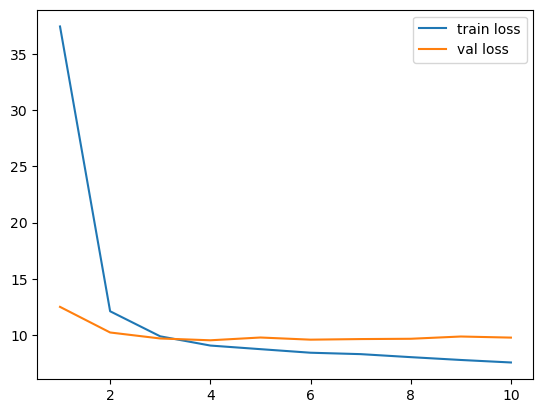

In [26]:
plt.plot(np.arange(1,10+1), history3.history['loss'], label='train loss')
plt.plot(np.arange(1,10+1), history3.history['val_loss'], label='val loss')
plt.legend()
plt.show()

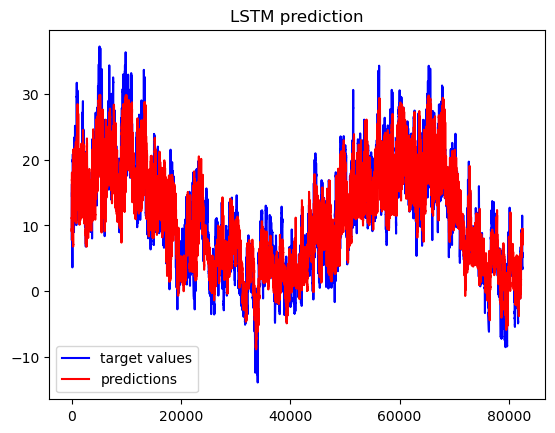

In [23]:
predictions3 = model3.predict(test_dataset)
predictions3 = predictions3.reshape((test_num,))

x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions3, label = 'predictions', color='r')
plt.title('LSTM prediction')
plt.legend()
plt.show()

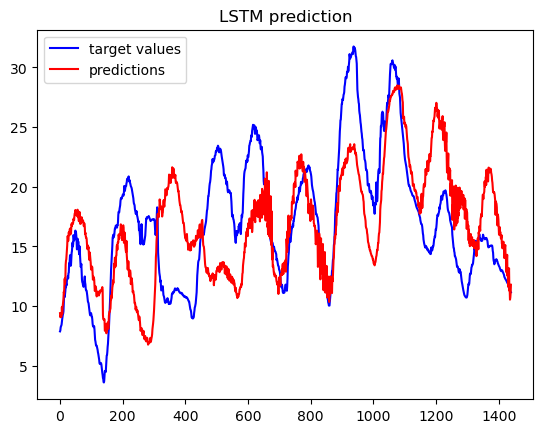

In [30]:
x = np.arange(1440)
plt.plot(x, test_targets[:1440], label = 'target values', color='b')
plt.plot(x, predictions3[:1440], label = 'predictions', color='r')
plt.title('LSTM prediction')
plt.legend()
plt.show()

## Future Works

- Bidirectional RNN
- Stacked LSTM
- GRU